In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import ee
import geemap
from PIL import Image, ImageSequence
import numpy as np
import urllib


ee.Authenticate()
ee.Initialize(project='landsat-test01')


In [36]:
lat=37
lon=-5

region = ee.Geometry.Rectangle([lon-2, lat-1, lon+2, lat+1])

date_i='2020-01-01'
date_f='2022-01-01'
dates=(date_i,date_f)


# Applies scaling factors.
def Landsat_apply_factors(image):
  '''
   Apply scale factors to Landsat 8 satellite
   function taken on earh engine Data catalog for landsat T1_L2
  '''
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)       ##surface reflectance bands
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    ## surface temperature bands
  return image.addBands(optical_bands, None,overwrite= True).addBands(
      thermal_bands, None,overwrite= True
  )

def Sentinel_apply_factors(image):
    '''
    Apply scale factor to Sentinel2 satellite
    this could be done without additionnal function, I made it to be consistent with
    the procedure for Landsat 8 satellite
    '''
    return image.divide(10000)



def  getCollection(sat,dates,region):
    if sat=='era5':
        sat_id='ECMWF/ERA5_LAND/DAILY_AGGR' #land hourly data ; weather related data
    elif sat=='landsat':
        sat_id= 'LANDSAT/LC08/C02/T1_L2'#  Landsat 8, collection 2, niveau 1 uniquement
    elif sat=='sentinel':
        sat_id='COPERNICUS/S2_HARMONIZED' #the harmonized prodcut, better?
    else:
        print('no Sat')
        return
    #
    mySat= ee.ImageCollection(sat_id)\
        .filterDate(dates[0],dates[1]) \
        .filterBounds(region) \
        #.filter(ee.Filter.listContains('system:time_start'))
        #.first()#Returns the first entry from a given collection. for test


    #scaling factors must be applied on the whole collection
    if sat_id=='landsat':
      mySat=mySat.map(Landsat_apply_factors)
    elif sat_id=='sentinel':
      mySat=mySat.map(Sentinel_apply_factors)

    ##REMOVE too cloudy image,
    # not for Era5  as it a a reanalysis
    #keep image with less than x% of cloud / remove too cloudy images
    if sat_id=='sentinel':
        mySat=mySat.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))

    if sat_id=='landsat':
      mySat=mySat.filter(ee.Filter.lt('CLOUD_COVER', 60))
    return mySat


######################## PIXEL QA cleaning##################################
def Sent_QAmask(image):
    '''
    Remove pixel with bad quality and pixel with cloud
    For Sentinel 2 satellite
    NO saturation mask is applied, I don't know if it is possible
    '''
    quality_band = image.select('QA60')
    cloudmask = 1<<10
    cirrusmask = 1<<11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) \
    and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    #saturation mask is?
    return image.updateMask(mask)


def Land_QAmask(image):
    '''
    Remove pixel with bad quality and pixel with cloud
    For Landsat2 satellite
    A saturation mask is also applied
    #see https://developers.google.com/earth-engine/tutorials/community/time-series-modeling
    #see https://gis.stackexchange.com/questions/405056/understanding-the-cloud-mask-in-google-earth-engine
    '''
    quality_band = image.select('QA_PIXEL')
    cloudmask = 1 << 4
    cloudshadowmask = 1 << 5
    mask = quality_band.bitwiseAnd(cloudshadowmask).eq(0) \
    and (quality_band.bitwiseAnd(cloudmask).eq(0))
    saturationMask = image.select('QA_RADSAT').eq(0)
    return image.updateMask(mask).updateMask(saturationMask)






####################COMPUTE spectralindex


#index
#search on https://custom-scripts.sentinel-hub.com/custom-scripts/
#or on https://www.bikeshbade.com.np
#or on https://esri.com
#oron https://www.earthdatascience.org
def compute_ndvi(image):
    '''
    Compute Normalized Difference Vegetation Index
    photosynthetically active biomass / vegetation health
    NDVI = (NIR-RED)/(NIR+RED)
    '''
    ndvi = image.normalizedDifference([BAND['nir'], BAND['red']]).rename('NDVI')
    return image.addBands(ndvi)


def compute_ndwi(image):
    '''
    Compute Normalized Difference Water Index # also called NDMI where M=moisture
    change in the water content of leaves /moisture index /water stress and drought
    NDWI = (NIR-SWIR1)/(NIR+SWIR1)
    '''
    ndwi = image.normalizedDifference([BAND['nir'], BAND['swir1']]).rename('NDWI')
    return image.addBands(ndwi)


def compute_bsi(image):
    '''
    Compute Bare Soil Index
    quantify soil mineral composition and land degradation ;crop identification?
    BSI=((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE))
    '''
    bsi= image.expression('((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE))',
                           {'NIR' : image.select(BAND['nir']),
                            'RED' : image.select(BAND['red']),
                            'BLUE': image.select(BAND['blue']),
                            'SWIR' : image.select(BAND['swir2'])
                            }
                            ).rename('BSI')
    return image.addBands(bsi)


def compute_satvi(image):
    '''
    Compute soil adjusted total vegetation Index
    vegetation index  as ndvi but more stable and reduce the impact of soil brightness on vegetation
    SATVI= ((SWIR1 - RED) / (SWIR1 + RED + L)) * (1 + L) - (SWIR2 / 2)
    L= 0.5 or 1 usually, L= 0.5 here
    see https://medium.com/@muhammad.shahnoor/remote-sensing-soil-indices-google-earth-engine-8234511d730d
    '''
    satvi=image.expression('((SWIR1 - RED) / (SWIR1 + RED + L)) * (1 + L) - (SWIR2 / 2)',
                           {'SWIR1': image.select(BAND['swir1']),
                            'RED': image.select(BAND['red']),
                            'SWIR2': image.select(BAND['swir2']),
                            'L': 0.5
                            }
                            ).rename('SATVI')
    return image.addBands(satvi)


def compute_evi(image):
  '''
  Enhanced Vegetation Index ; ndvi but modified to enchance vegetation signal
  https://en.wikipedia.org/wiki/Enhanced_vegetation_index
  between -1 and 1
  EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))
  '''
  evi=image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                          {'NIR': image.select(BAND['nir']),
                          'RED': image.select(BAND['red']),
                          'BLUE': image.select(BAND['blue'])
                          }
                          ).rename('EVI')
  return image.addBands(evi)


def compute_lai(image):
  '''
  Leaf Area Index
  see https://kaflekrishna.com.np/blog-detail/retrieving-leaf-area-index-lai-sentinel-2-image-google-earth-engine-gee/
  require previous calculation of EVI, formula base on a blog... not very sure if it is correct
  '''
  lai=image.expression('3.618*EVI-0.118',
                      {'EVI':image.select('EVI')}
                        ).rename('LAI')
  return image.addBands(lai)


def compute_gndvi(image):
  '''
  Green Normalized Difference Vegetation Index
  see https://www.soft.farm/en/blog/vegetation-indices-ndvi-evi-gndvi-cvi-true-color-140
  '''
  gndvi = image.normalizedDifference([BAND['nir'], BAND['green']]).rename('GNDVI')
  return image.addBands(gndvi)


def compute_cvi(image):
  '''
  Chlorophyll Vegetation Index
  see https://www.soft.farm/en/blog/vegetation-indices-ndvi-evi-gndvi-cvi-true-color-140
  '''
  cvi=image.expression('NIR*RED/GREEN/GREEN',
                        {'NIR':image.select(BAND['nir']),
                         'RED':image.select(BAND['red']),
                         'GREEN':image.select(BAND['green'])
                        }).rename('CVI')

  return image.addBands(cvi).addBands(cvi)



##########################################################
##########################################################
############################# END of function definitions




############################# GET DATA, apply QA, compute spectralindex

#1 - get data
Era5=getCollection('era5',dates,region)
Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)

#2 - Bands names
#band_era=Era5.first().bandNames().getInfo() #same as bandnames, ok ; meteo  for later
band_LS=Landsat.first().bandNames().getInfo() #band B1 to B12 + QA_PIXEL+QA_RADARSAT +others
band_Sent=Sentinel.first().bandNames().getInfo() #band B1 to B11 + some QA +others

#sentinel bands
codes = ['QA60','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']
names = ['QA60','blue','green','red','re1','re2','re3','nir','re4','waterVapor','cirrus','swir1','swir2']
S_BAND=dict([(n,c) for c,n in zip(codes,names)])

#landsat 8 bands
#this not l2level codes=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']#, 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA']
#this is not l2 level names=['Coastal','blue','green','red','nir','swir1','swir2','pan','cirrus','tirs1','tirs2']
#see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#bands
codes=['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
names=['Coastal','blue','green','red','nir','swir1','swir2'] # Ithink
L8_BAND=dict([(n,c) for c,n in zip(codes,names)])


#3 - compute index
Features=['NDVI','NDWI','BSI','SATVI','EVI','LAI','GNDVI','CVI']


BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)
Sentinel=Sentinel.map(compute_ndwi)
Sentinel=Sentinel.map(compute_bsi)
Sentinel=Sentinel.map(compute_satvi)
Sentinel=Sentinel.map(compute_evi)
Sentinel=Sentinel.map(compute_lai)
Sentinel=Sentinel.map(compute_gndvi)
Sentinel=Sentinel.map(compute_cvi)


BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)
Landsat=Landsat.map(compute_ndwi)
Landsat=Landsat.map(compute_bsi)
Landsat=Landsat.map(compute_satvi)
Landsat=Landsat.map(compute_evi)
Landsat=Landsat.map(compute_lai)
Landsat=Landsat.map(compute_gndvi)
Landsat=Landsat.map(compute_cvi)


#############################  2D MAP visualisation parameters

palette0=[ 'yellow', 'green','blue']
palette1 = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']
#vis_params = {"min":0.0, "max":1,"palette": ['B4','B3','B2']}



#Map = geemap.Map(center=[lat, lon],zoom=6)

#image.getInfo()

In [37]:
vis_params={'min': -.1, 'max': 1,
            'palette': palette1}

Features=['NDVI','NDWI','BSI','SATVI','EVI','LAI','GNDVI','CVI']
#problem with SATVI
feature='GNDVI'


image=Landsat.median().clip(region)
#print(image.select(feature))
Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select(feature), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map.add_colorbar(vis_params,layer_name=feature,label=feature)
Map



Map(center=[37.012387995499594, -5.000000000000045], controls=(WidgetControl(options=['position', 'transparent…

In [38]:
#same index or band but for Sentinel

image=Sentinel.median().clip(region)
Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select(feature), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map


Map(center=[37.012387995499594, -5.000000000000045], controls=(WidgetControl(options=['position', 'transparent…

In [39]:
image.bandNames().getInfo()


Minmax=image.select('B8').reduceRegion(ee.Reducer.minMax(),geometry=region).values().getInfo()
print (Minmax)

#Sentinel.toList(4).getInfo()[0]['properties']

[3372.5, 277.625]


In [40]:
# Visualisation with false color for Sentinel
# see https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

image_viz_params = {
    'bands': ['B8', 'B4', 'B3'],
    'min': 0,
    'max': 3500,
    'gamma': [0.95, 1.1, 1],
}

# Define a map centereon area of interest
Map = geemap.Map()
Map.centerObject(region, 8)
Map.add_layer(image, image_viz_params, 'false color composite')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map



Map(center=[37.012387995499594, -5.000000000000045], controls=(WidgetControl(options=['position', 'transparent…

In [41]:
# code to save some figure locally, both in jpg and in tif if asked
#download data to '/content' in collab and in local directory on a computer
#8-10mn to run, unfortunatley, increase scale in tif to reduce time

def save_figure(image,satname,vis_params,feature, jpg_only=None):
    #

    if jpg_only is None:
        jpg_only=True


    #save image in local, as tif
    if jpg_only==False: # get image in tif only if asked
      projection = image.select(0).projection().getInfo()
      geemap.ee_export_image( image.select(feature),
                              filename=satname+'_'+feature+'.tif',
                              scale=1000, #higher mean less computation time
                              crs=projection['crs'], #useful?
                              region=region
                             )


    #save image in local, as jpg
    out_img=satname+'_'+feature+'.jpg'
    geemap.get_image_thumbnail(image.select(feature),
                                  out_img,
                                  vis_params=vis_params,
                                  dimensions=420,
                                  region=region
                               )
    #geemap.show_image(out_img)


# ############### Save figure
#### this is time median over all data!!!

# for feature in Features:
#   save_figure(image=Sentinel .median().clip(region),
#              satname='Sentinel',
#              vis_params=vis_params,
#              feature=feature)

#   save_figure(image=Landsat .median().clip(region),
#              satname='Landsat',
#              vis_params=vis_params,
#              feature=feature)




In [42]:
#### make some animation of different index



#https://developers.google.com/earth-engine/guides/ic_visualization?hl=fr
# for join, see also https://developers.google.com/earth-engine/guides/joins_save_all?hl=fr
#make animated gif!



# Define GIF visualization arguments.
gifParams = {
    'region': region,
    'dimensions': 420,
    'crs': 'EPSG:3857',
    'framesPerSecond': 1, # Increased frames per second
    'format': 'gif'
}

#visual parameter
vis_params={'min': -.1, 'max': 1,
            'palette': palette1}



# Create RGB visualization images for use as animation frames.
def visualize_and_clip(img):
    # Clip the image to the region defined in gifParams
    return img.visualize(**vis_params).clip(region)


#add day
def add_date(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.set('date',img_date.toInt())


# Add day-of-year (DOY) property to each image.
def add_doy(img):
    doy = ee.Date(img.get('system:time_start')).getRelative('day', 'year')
    return img.set('doy', doy)



def create_gif(collection, feature, gifParams, interval_days=None,overlap=None):
  '''
  Creates a GIF from an Earth Engine ImageCollection.

  Args:
    collection: The Earth Engine ImageCollection.
    feature: The band/feature to visualize.
    gifParams: Dictionary of GIF visualization parameters.
    interval_days: The time interval in days between frames.
                   If None, creates a GIF for each unique date.
    overlap: time overlap between one frame and and next one, in percentage
              if 1, it means an interval is used twice, for a given frame and the next one
              If None, overlap is 0%
  Returns:
    The filename of the saved GIF.
  '''

  #Default option
  if interval_days is None:
    interval_days=16
  if overlap is None: #overlap is in percentage 0: no overlap 1=100%overlap on each side!
    overlap=0

  delta=interval_days/(2-overlap)

  # Keep only one feature to have lighter collection
  collection = collection.select(feature)


  # Create a list of dates at the specified interval
  start_date = ee.Date(date_i).advance(interval_days/2,'day')
  end_date = ee.Date(date_f).advance(-interval_days/2,'day')
  n_days = end_date.difference(start_date, 'day')
  n_steps = n_days.divide(interval_days).ceil().getInfo()
  dates_list = [start_date.advance(i * interval_days, 'day') for i in range(n_steps)]

  # Filter the collection to get images closest to the specified dates
  def get_closest_image(date):
      # Look for images within a window of half the interval before and after the date
      return collection.filterDate(date.advance(-delta, 'day'),
                                    date.advance(delta, 'day')
                                    ).median() # Use median to get a composite image if multiple are found


  comp_list = [get_closest_image(date) for date in dates_list]
  # Filter out None images from the list
  comp_list = [img for img in comp_list if img is not None]


  comp = ee.ImageCollection.fromImages(comp_list)

  print(f"Number of images in collection for GIF: {comp.size().getInfo()}") # Print number of images


  # create the RGB visualization
  rgbVis = comp.map(visualize_and_clip)

  # create gif and get the url
  url = rgbVis.getVideoThumbURL(gifParams)

  #save the gif created at the url adress
  #file2save = f"{satname}_{feature}_animation_{interval_days}days.gif"
  file2save = f"{satname}_{feature}_animation.gif"


  urllib.request.urlretrieve(url,file2save)

  return file2save

collection=Landsat
satname='Landsat'
feature='GNDVI'

# Example usage: create a GIF with frames every 30 days
file2save = create_gif(collection, feature, gifParams, interval_days=30,overlap=.25)
if file2save: # Only show image if GIF was created
    geemap.show_image(file2save)

Number of images in collection for GIF: 24


Output()

In [43]:
#### make some gif

# collection=Landsat
# satname='Landsat'
# for feature in Features:
#   print(feature)
#   create_gif(collection,feature,gifParams,interval_days=365//12,overlap=.25)

# collection=Sentinel
# satname='Sentinel'
# for feature in Features:
#   print(feature)
#   create_gif(collection,feature,gifParams,interval_days=365//12,overlap=.25)




In [44]:

def add_month(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('MM'))
    #return image.addBands(ee.Image(img_date).rename('date').toInt())
    #img.set('date',img_date)
    return image.set('month',img_date.toInt())



def create_gif_month(collection,feature,gifParams):
  ''' similar as before, but by month, if multi year, all same month are together '''

  #keep only one feature to have lighter collection
  collection = collection.select(feature)

  #define month_year
  collection = collection.map(add_month)

  # Get a list of distinct month values
  #fail!!! distinct_month_list =  ee.List.sequence(1, 12)
  distinct_month_list = collection.aggregate_array('month').distinct().sort().getInfo()

  # Map over the distinct month_year values and reduce to median
  def median_by_month(month):
      monthly_collection = collection.filterMetadata('month', 'equals', month)
      return monthly_collection.median().set('month', month)

  comp_list = [median_by_month(my) for my in distinct_month_list]
  comp = ee.ImageCollection.fromImages(comp_list)

  print(f"Number of images in collection for GIF: {comp.size().getInfo()}") # Print number of images

  # create the RGB visualization
  rgbVis = comp.map(visualize_and_clip)

  # create gif and get the url
  url = rgbVis.getVideoThumbURL(gifParams)

  #save the gif created at the url adress
  file2save = satname+'_'+feature+'_animation_month.gif'
  urllib.request.urlretrieve(url,file2save)

  return file2save

collection=Landsat
satname='Landsat'
feature='GNDVI'

file2save=create_gif_month(collection,feature,gifParams)
geemap.show_image(file2save)

Number of images in collection for GIF: 12


Output()

(23, 266, 420, 3)


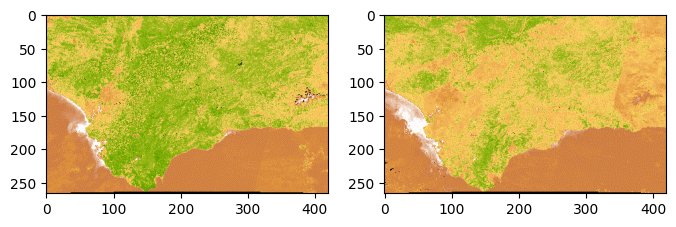

In [45]:


def load_gif(file):
  '''
  load gif and return a list of frames
  ignore index 0... not same format as other images, dont know what it is
  output is times*lat,lon,color!
  '''

  img=Image.open(file)

  frames=[]
  index=0
  for frame in ImageSequence.Iterator(img):
    if index>0:
      frames.append(np.array(frame))
    index+=1
  #print(index)
  return np.array(frames)

frames=load_gif(file=file2save)

#z=np.array(frames)
#print(z.shape)



###..................what if a combine animation????
frames_0=load_gif(file='Landsat_GNDVI_animation.gif')
#frames_1=load_gif(file='Landsat_NDWI_animation.gif')

#### note : maybe later, directly make a formula to get a new feature instead of working
## with gif
test=frames_0#+frames_1
print(test.shape)

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(test[0,...])
ax[1].imshow(test[-1,...])
fig.show()


#####!!!!!!!!!!!!!!!!!!!multiple index are on the same colorrange and value of range,
####ok or not???


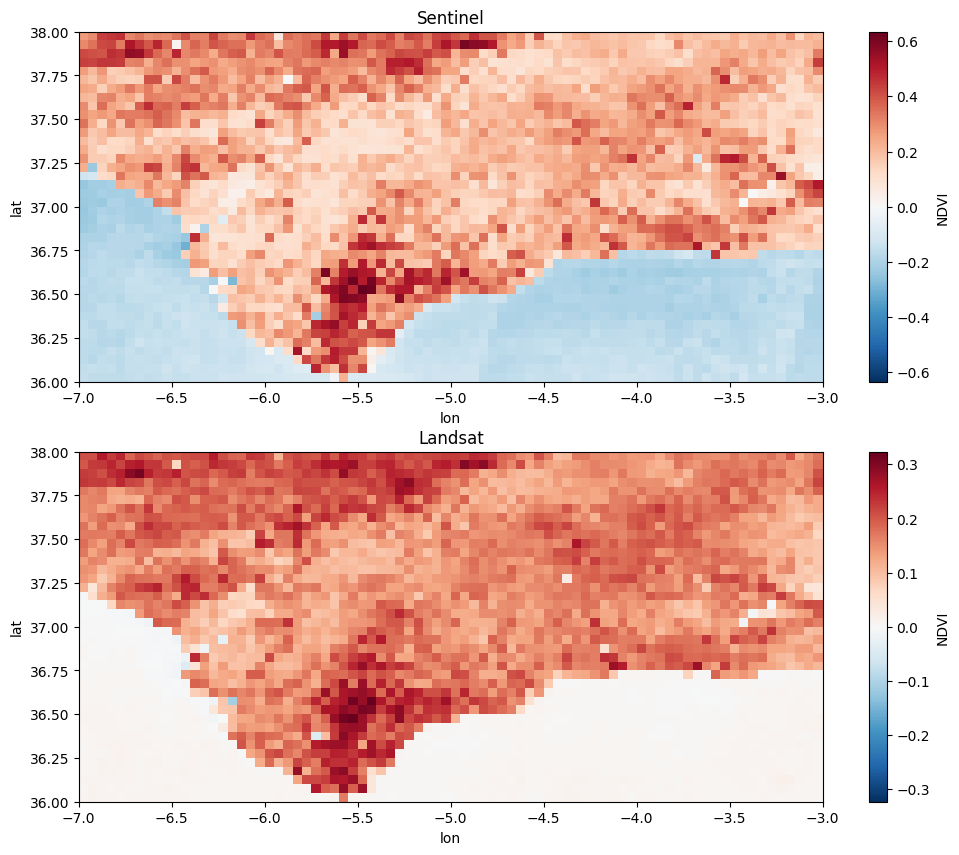

In [46]:

#################################### now that we have a good visualisation, get complementary data and  create dataset with xarray


###############test ee_to xarray!


#1deg at midlatitude about 110km in latitude
#0.01 deg is about 110/100=1.1km
resol=0.05 #this is about 4.5km

Sentinel_ds=geemap.ee_to_xarray(Sentinel.median(),
                                crs='EPSG:4326',
                                scale=resol, #scale is the resolution in crs coord (here lat,lon)
                                geometry=region,
                                ee_initialize=False)

Landsat_ds=geemap.ee_to_xarray(Landsat.median(),
                               crs='EPSG:4326',
                               scale=resol, #scale is the resolution in crs coord (here lat,lon)
                               geometry=region,
                               ee_initialize=False)

feature='NDVI'
fig,ax=plt.subplots(2,1,figsize=(12,10))
Sentinel_ds[feature].plot(x='lon',ax=ax[0])
Landsat_ds[feature].plot(x='lon',ax=ax[1])

ax[0].set_title('Sentinel')
ax[1].set_title('Landsat')

fig.show()

#print(len(Sentinel_ds.lon))
#print(len(Sentinel_ds.lat))

In [47]:
# A digital elevation model (DEM).
# import matplotlib.cm as cm
# cmap = cm.get_cmap('viridis')
# num_colors = 4
# colors = [cmap(i/float(num_colors-1)) for i in range(num_colors)]


DEM='NASA/NASADEM_HGT/001' # elevation model without tree, building and others stuff.
#DEM='JAXA/ALOS/AW3D30/V4_1'#     ''   ''      with   ''      ''     ''  ''     ''
# for ALOS mode, call DSM instead elevation!
dem = ee.Image(DEM).select('elevation').clip(region)

# Calculate slope. Units are degrees, range is [0,90).
slope = ee.Terrain.slope(dem)


#visparam need colors in hex format,...
Visparam = {
  'min': 0,
  'max': 1500,
  'palette': ['041033','E5FFCC','662A00'],
}

# Display slope  on the map.
m = geemap.Map()
m.set_center(lon,lat,8)
m.add_layer(dem, Visparam, 'elevation (m)')
m.add_colorbar(Visparam, label="elevation (m)")
m


#see https://www.frontiersin.org/journals/environmental-science/articles/10.3389/fenvs.2024.1419041/full
#The slope map was generated, categorizing the terrain into six distinct slope classes:
# flat plains (≤5%),
# gentle slopes (5%–10%),
# moderate slopes (11%–15%),
# moderately steep slopes (16%–20%),
# steep slopes (21%–25%),
# and very steep slopes (>25%).

#this legend is slightly modified... steep and very steep are together
Slope_legend={
'flat':'0-5',
'gentle':'5-10',
'moderate':'10-15',
'light_steep':'15-20',
'steep':'20-40'}


In [48]:
#visparam need colors in hex format,...
Visparam = {
  'min': 0,
  'max': 20,
  'palette': ['041033','E5FFCC','662A00'],
}

# Display slope  on the map.
m = geemap.Map()
m.set_center(lon,lat,8)
m.add_layer(slope, Visparam, 'Slope (deg)')
m.add_colorbar(Visparam, label="Slope (deg)")
m


Map(center=[37, -5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [49]:
### Land use /land cover
# 2 choices -Copernicus  100m resol but a lot of classes
#            -ESA         10m resol but less classes


#LULC = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019').select('discrete_classification')

LULC=ee.ImageCollection('ESA/WorldCover/v200').first().select('Map')

# this are the classes for ESA word cover!
ee_class_table = '''
Value 	Color 	Description
10 	#006400 	Tree cover
20 	#ffbb22 	Shrubland
30 	#ffff4c 	Grassland
40 	#f096ff 	Cropland
50 	#fa0000 	Built-up
60 	#b4b4b4 	Bare / sparse vegetation
70 	#f0f0f0 	Snow and ice
80 	#0064c8 	Permanent water bodies
90 	#0096a0 	Herbaceous wetland
95 	#00cf75 	Mangroves
100 	#fae6a0 	Moss and lichen
'''

LULC_legend = geemap.legend_from_ee(ee_class_table)

m = geemap.Map()
m.set_center(lon,lat,8)
m.add_layer(LULC, {}, 'Land Use Land Cover')
m.add_legend(legend_title='',
             legend_dict=LULC_legend)
m



Map(center=[37, -5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [50]:
LULC_legend

{'10 Tree cover': '#006400',
 '20 Shrubland': '#ffbb22',
 '30 Grassland': '#ffff4c',
 '40 Cropland': '#f096ff',
 '50 Built-up': '#fa0000',
 '60 Bare / sparse vegetation': '#b4b4b4',
 '70 Snow and ice': '#f0f0f0',
 '80 Permanent water bodies': '#0064c8',
 '90 Herbaceous wetland': '#0096a0',
 '95 Mangroves': '#00cf75',
 '100 Moss and lichen': '#fae6a0'}

In [51]:
#surface temperature and evaporation
#Era5 is in my function getcollection, along with the multispectralsatellite
# Era5= weather reanalysis

#https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview
# -> Era5 resolution is 0.1 degree,i.e around 9km

Era5=getCollection('era5',dates,region)

#note, for evaporation negative values indicate evaporation and positive values indicate condensation.
#note, 'evaporation_from_bare_soil_sum', has some issues by ECMWF

Weather=Era5.select(['temperature_2m',
                     'total_precipitation_sum',
                     'evaporation_from_vegetation_transpiration_sum',
                     'evaporation_from_bare_soil_sum',
                     'total_evaporation_sum',
                     'u_component_of_wind_10m',
                     'v_component_of_wind_10m',
                     ])

vis_params1 = {
'bands': ['evaporation_from_bare_soil_sum'],
  'min': -0.001,
  'max': 0.0000,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
};

vis_params2 = {
  'bands': ['temperature_2m'],
  'min': 280,
  'max': 295,#-10,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
};


#feature='total_evaporation_sum';vis_params=vis_params1
feature='temperature_2m';vis_params=vis_params2

image=Weather.median().clip(region)

m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(image, vis_params2, feature);
m.add_colorbar(vis_params,layer_name=feature,label=feature)
m


Map(center=[37.012387995499594, -5.000000000000045], controls=(WidgetControl(options=['position', 'transparent…

Frozen({'time': 1, 'lon': 200, 'lat': 100})

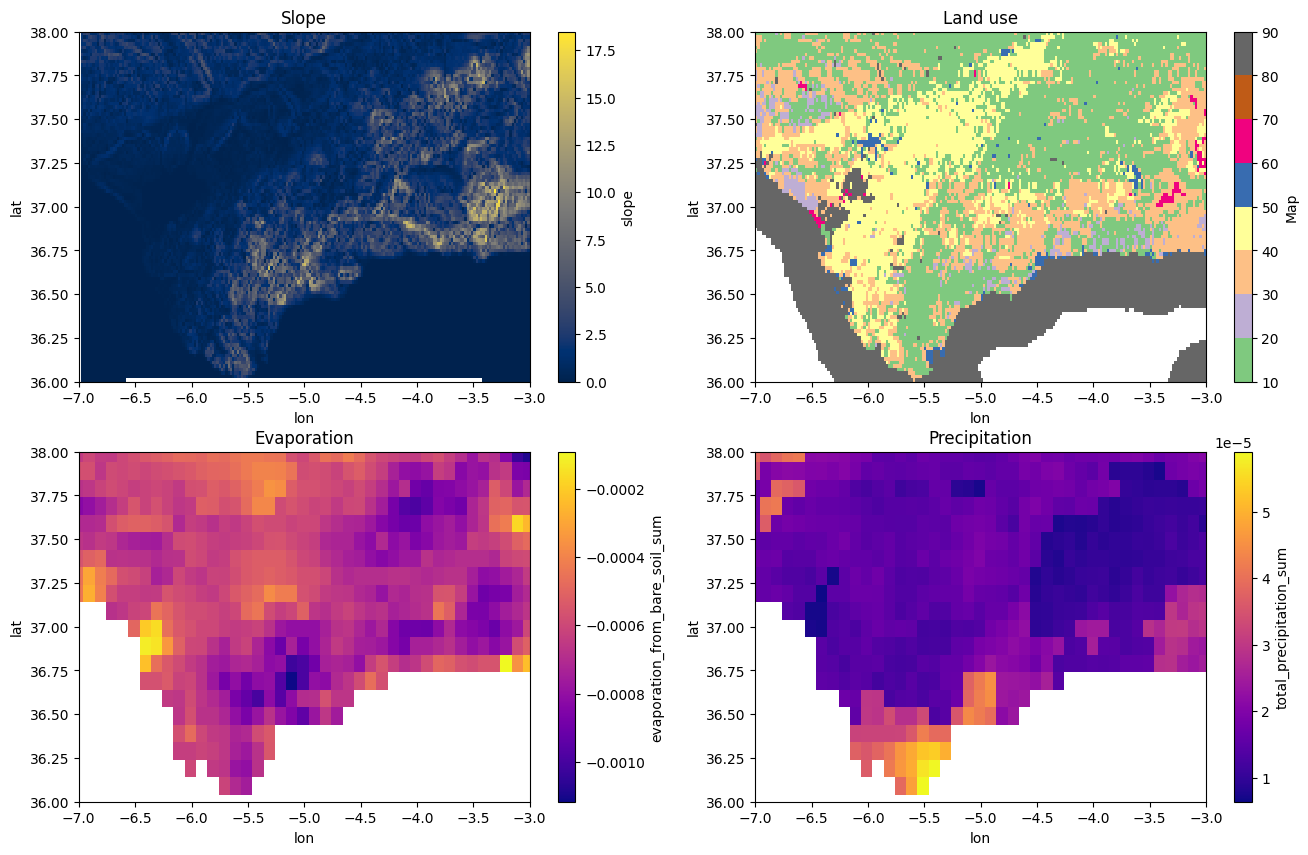

In [52]:
#convert in xarray

#0.01 degree is around 1.1 km
resol=0.02

Sentinel_ds=geemap.ee_to_xarray(Sentinel.median(),
                                crs='EPSG:4326',
                                scale=resol, #scale is the resolution in crs coord (here lat,lon)
                                geometry=region,
                                ee_initialize=False)

Landsat_ds=geemap.ee_to_xarray(Landsat.median(),
                               crs='EPSG:4326',
                               scale=resol, #scale is the resolution in crs coord (here lat,lon)
                               geometry=region,
                               ee_initialize=False)


DEM_ds=geemap.ee_to_xarray(dem,
                              crs='EPSG:4326',
                              scale=resol, #scale is the resolution in crs coord (here lat,lon)
                              geometry=region,
                              ee_initialize=False)

DEMSlope_ds=geemap.ee_to_xarray(slope,
                              crs='EPSG:4326',
                              scale=resol, #scale is the resolution in crs coord (here lat,lon)
                              geometry=region,
                              ee_initialize=False)


LULC_ds=geemap.ee_to_xarray(LULC,
                            crs='EPSG:4326',
                            scale=resol, #scale is the resolution in crs coord (here lat,lon)
                            geometry=region,
                            ee_initialize=False)


Weather_ds = geemap.ee_to_xarray(Weather.median(),
                                 crs='EPSG:4326',
                                 scale=resol, #scale is the resolution in crs coord (here lat,lon)
                                 geometry=region,
                                 ee_initialize=False,
                                 )


Weather_ref_ds = geemap.ee_to_xarray(Weather.median(),
                                 crs='EPSG:4326',
                                 scale=.1, #see https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview
                                 geometry=region,
                                 ee_initialize=False,
                                 )

fig,ax=plt.subplots(2,2,figsize=(16,10))
DEMSlope_ds.slope.plot(x='lon',cmap='cividis',ax=ax[0,0])
LULC_ds.Map.plot(x='lon',cmap='Accent',ax=ax[0,1])
Weather_ds.evaporation_from_bare_soil_sum.plot(x='lon',cmap='plasma',ax=ax[1,0])
Weather_ds.total_precipitation_sum.plot(x='lon',cmap='plasma',ax=ax[1,1])

ax[0,0].set_title('Slope')
ax[0,1].set_title('Land use')
ax[1,0].set_title('Evaporation')
ax[1,1].set_title('Precipitation')

fig.show()

#shape=LULC_ds.sizes
#shape['lon']

#Weather_ds
DEM_ds.sizes

In [53]:
Sentinel_ds

<xarray.Dataset> Size: 2MB
Dimensions:              (time: 1, lon: 200, lat: 100)
Coordinates:
  * time                 (time) int64 8B 0
  * lon                  (lon) float64 2kB -6.99 -6.97 -6.95 ... -3.03 -3.01
  * lat                  (lat) float64 800B 36.01 36.03 36.05 ... 37.97 37.99
Data variables: (12/28)
    B1                   (time, lon, lat) float32 80kB ...
    B2                   (time, lon, lat) float32 80kB ...
    B3                   (time, lon, lat) float32 80kB ...
    B4                   (time, lon, lat) float32 80kB ...
    B5                   (time, lon, lat) float32 80kB ...
    B6                   (time, lon, lat) float32 80kB ...
    ...                   ...
    SATVI                (time, lon, lat) float32 80kB ...
    EVI                  (time, lon, lat) float32 80kB ...
    LAI                  (time, lon, lat) float32 80kB ...
    GNDVI                (time, lon, lat) float32 80kB ...
    CVI                  (time, lon, lat) float32 80kB ...
    CVI_1                (time, lon, lat) float32 80kB ...
Attributes:
    crs:      EPSG:4326

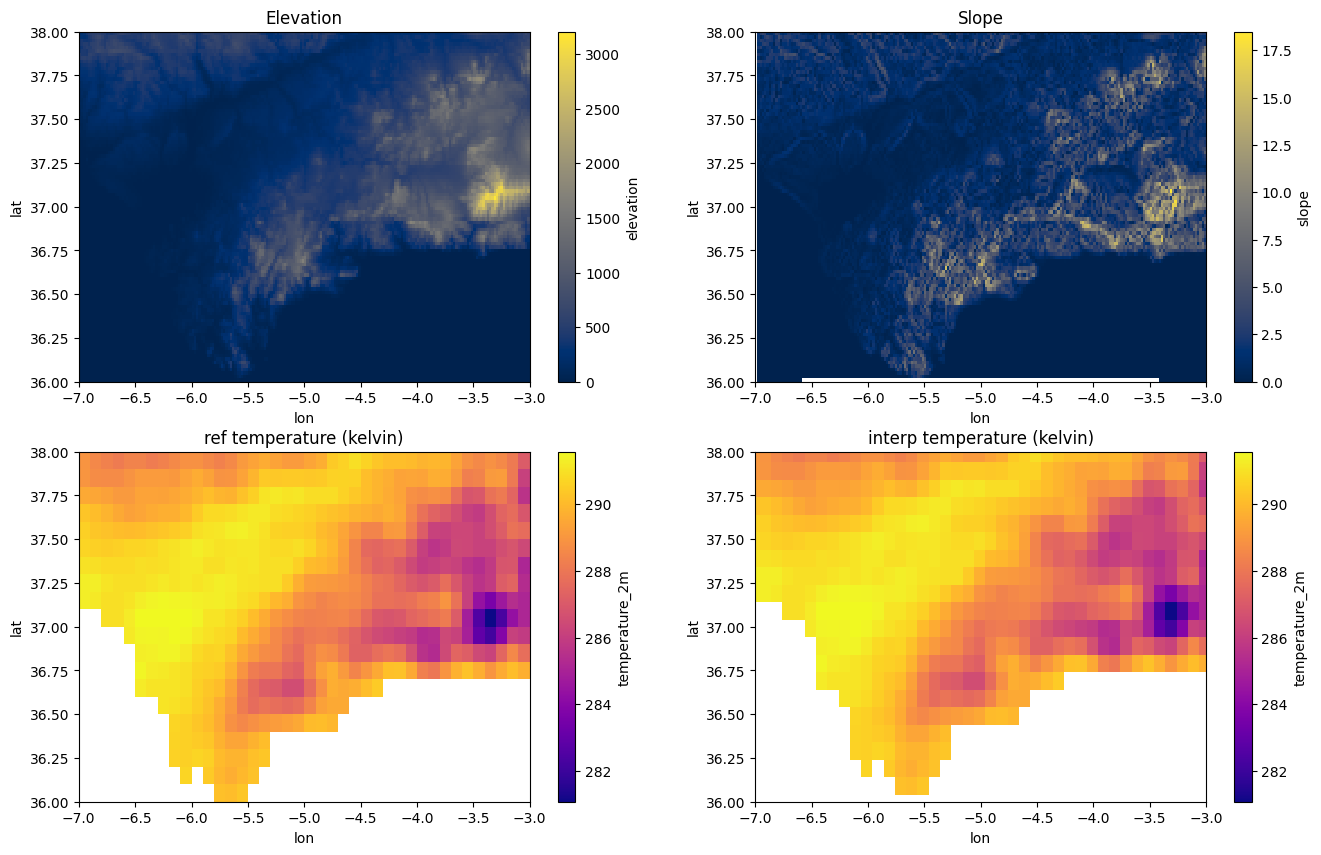

In [54]:
#### check resolution change on temperature

fig,ax=plt.subplots(2,2,figsize=(16,10))
DEM_ds.elevation.plot(x='lon',cmap='cividis',ax=ax[0,0])
DEMSlope_ds.slope.plot(x='lon',cmap='cividis',ax=ax[0,1])
Weather_ref_ds.temperature_2m.plot(x='lon',cmap='plasma',ax=ax[1,0])
Weather_ds.temperature_2m.plot(x='lon',cmap='plasma',ax=ax[1,1])

ax[0,0].set_title('Elevation')
ax[0,1].set_title('Slope')
ax[1,0].set_title('ref temperature (kelvin)')
ax[1,1].set_title('interp temperature (kelvin)')

fig.show()



In [55]:
################## see era5 temperature natural resolution and xarray product at new (better) resolution... not convinced by this 'downscaling'

# try:
#   import TopoPyScale
#   print('Toposcale installed')
# except:
#   !pip install TopoPyScale

# try:
#   import cfgrib
# except:
#   !pip install cfgrib

# from TopoPyScale import topoclass as tc


############################## DO a proper downscaling for Era data

###############seee later this will be harder than expected!

owslib installed
wms service found
Layer Name: REDIAM, Title: REDIAM. WMS Riesgo de desertificación en Andalucía. Periodo: 1956-2100
Layer Name: riesgo_desertificacion_1956, Title: Riesgo desertificación 1956
Layer Name: riesgo_desertificacion_1999, Title: Riesgo desertificación 1999
Layer Name: riesgo_desertificacion_2003, Title: Riesgo desertificación 2003
Layer Name: riesgo_desertificacion_2040, Title: Riesgo desertificación 2040
Layer Name: riesgo_desertificacion_2070, Title: Riesgo desertificación 2070
Layer Name: riesgo_desertificacion_2100, Title: Riesgo desertificación 2100
(100396.0, 3987110.0, 621305.0, 4288780.0, 'EPSG:3042')
(-7.429393785736579, -1.6042523168349947) (35.94665781856804, 38.7393741332995)


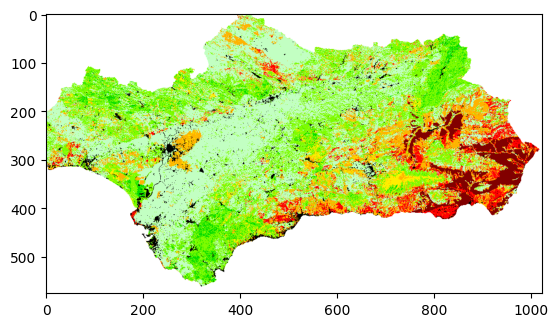

In [56]:
####  desertification risks???
#i.e image classification , with ResNet34???

try:
  import owslib
  print('owslib installed')
except:
  !pip install owslib

from owslib.wms import WebMapService
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import io
from pyproj import Transformer
import rasterio



#seee https://portalrediam.cica.es/geonetwork/srv/fre/catalog.search#/metadata/e9d73174-b9b8-496d-b0f8-87550c1c4e6d
#4 maps exist, heritage, actual, sensitivity and risks, I think risks is the best to use, but sentivity could be interesting too
# risk is consquecence of heritage,sensitivity, and actual
# heritage : https://portalrediam.cica.es/VisorRediam/?lyr.add.wms=http%3A%2F%2Fwww.juntadeandalucia.es%2Fmedioambiente%2Fmapwms%2FREDIAM_desertificacion_heredada_1956_2100%3F
# situation actual : https://portalrediam.cica.es/VisorRediam/?lyr.add.wms=http%3A%2F%2Fwww.juntadeandalucia.es%2Fmedioambiente%2Fmapwms%2FREDIAM_desertificacion_actual_1956_2100%3F
# sensitivity : https://portalrediam.cica.es/VisorRediam/?lyr.add.wms=http%3A%2F%2Fwww.juntadeandalucia.es%2Fmedioambiente%2Fmapwms%2FREDIAM_sensibilidad_desertificacion_1956_2100%3F
# risks : https://portalrediam.cica.es/VisorRediam/?lyr.add.wms=http%3A%2F%2Fwww.juntadeandalucia.es%2Fmedioambiente%2Fmapwms%2FREDIAM_riesgo_desertificacion_1956_2100%3F

# sensitivity is ESAI index, which is what I originally wanted, i.e land degradation + Desertificacion , but risk is more complete map
# sensitivity maps are different from what is in documents... critical area in orange and red have disapeared
# exemple of official document : DESERT_ART_EVALUACION_DESERTIFICACION or DESERT_POSTER_DESERNET_II_EN existing at https://portalrediam.cica.es/descargas/index.php/s/mxHMWXyHfrCxyNK?dir=/06_RIESGOS_NATURALES_TECNOLOG/01_RIESGOS_NATURALES/04_DESERTIFICACION/00_DESERTIFICACION/Desert_1956_2100/Documentos


#wms_ulr='http://www.juntadeandalucia.es/medioambiente/mapwms/REDIAM_desertificacion_heredada_1956_2100?'
#wms_url='https://www.juntadeandalucia.es/medioambiente/mapwms/REDIAM_sensibilidad_desertificacion_1956_2100?'
wms_url='https://www.juntadeandalucia.es/medioambiente/mapwms/REDIAM_riesgo_desertificacion_1956_2100?'


# The previous wms_url was pointing to a viewer, not the WMS service directly. Reverting to the actual WMS endpoint.
try:
  wms = WebMapService(wms_url,timeout=40) #their server is slow to answer
except:
  print(' you have to manually download a map from \n https://portalrediam.cica.es/descargas/index.php/s/mxHMWXyHfrCxyNK?dir=/06_RIESGOS_NATURALES_TECNOLOG/01_RIESGOS_NATURALES/04_DESERTIFICACION/00_DESERTIFICACION/Desert_1956_2100/InfGeografica/InfRaster/TIFF')
  wms=[]


if wms:
  print('wms service found')
  if 'riesgo' in wms_url:
    layer='riesgo_desertificacion_2003'
  if 'sensibilidad' in wms_url:
    layer='sensibilidad_desertificacion_2003'


# View available layers and their details
  for layer_name in list(wms.contents):
      print(f"Layer Name: {layer_name}, Title: {wms.contents[layer_name].title}")

  ##### Domain borders
  # get borders from wms boundingBox,
  wms_borders=wms.contents[layer].boundingBox   #see https://docs.geoserver.org/main/en/user/services/wms/reference.html
  print(wms_borders)

  transformer = Transformer.from_crs(wms_borders[-1], "EPSG:4326", always_xy=True)
  b_lon,b_lat=transformer.transform( (wms_borders[0], wms_borders[2]),  (wms_borders[1], wms_borders[3]))
  print(b_lon,b_lat)

  #rearanges borders to bbox convention minx,miny,maxx,maxy
  bbox=(b_lon[0],b_lat[0],b_lon[1],b_lat[1])


  map = wms.getmap(
    layers=[layer],
    srs='EPSG:4326', # Using EPSG:4326 for WGS84 lat/lon coordinates
    bbox=bbox,
    size=(1024,512+64), #here x,y!
    format='image/tiff',
    #transparent=True
    )

  img_bytes=map.read()
  # Use Pillow to open the image from bytes and then convert to numpy array
  img_pil = Image.open(io.BytesIO(img_bytes))
  risks=np.array(img_pil)
  #risks=img_pil.convert('L') # convert to gray level
  #risks=np.array(risks)

else:
  print('wms service not found, loading from local tif')
#domain border https://portalrediam.cica.es/geonetwork/srv/api/records/e9d73174-b9b8-496d-b0f8-87550c1c4e6d/formatters/datacite?approved=true
#bbox=( -7.521414, 35.938928,-1.626074,  38.730145)
  file_path = 'DESERT_RIESGO_2003.tif'

  # Open the GeoTIFF file
  with rasterio.open(file_path) as src:
    metadata=src.meta
    bbounds=src.bounds
    risks = src.read(1) #### this is in gray level already,... why not in rgb?

    transformer = Transformer.from_crs(metadata['crs'], "EPSG:4326", always_xy=True)
    b_lon,b_lat=transformer.transform( (bbounds[0], bbounds[2]),  (bbounds[1], bbounds[3]))

    #rearanges borders to bbox convention minx,miny,maxx,maxy
    bbox=(b_lon[0],b_lat[0],b_lon[1],b_lat[1])


plt.imshow(risks)


In [57]:
if wms:
  print(wms.contents['REDIAM'].__dict__.keys())
  print(wms.contents['REDIAM'].styles)
  print(wms.contents['REDIAM'].boundingBox)
  print(wms.contents['REDIAM'].index)

dict_keys(['auth', 'parent', 'index', '_children', 'id', 'name', 'queryable', 'cascaded', 'opaque', 'noSubsets', 'fixedWidth', 'fixedHeight', 'title', 'abstract', 'boundingBox', 'scaleHint', 'boundingBoxWGS84', 'crsOptions', 'styles', 'keywords', 'timepositions', 'defaulttimeposition', 'elevations', 'metadataUrls', 'dataUrls', 'layers'])
{'default': {'title': 'default', 'legend': 'https://www.juntadeandalucia.es/medioambiente/mapwms/REDIAM_riesgo_desertificacion_1956_2100?language=spa&version=1.1.1&service=WMS&request=GetLegendGraphic&layer=REDIAM&format=image/png&STYLE=default'}}
(100396.0, 3987110.0, 621305.0, 4288780.0, 'EPSG:3042')
1


In [58]:
#see .odt here https://portalrediam.cica.es/descargas/index.php/s/descargas?dir=/06_RIESGOS_NATURALES_TECNOLOG/01_RIESGOS_NATURALES/04_DESERTIFICACION/00_DESERTIFICACION/Desert_1956_2100/Documentos
# 2 case here:
#if wms exist, rgb colors are given but not completely consistent with
#if load image file through wml failed, I have multiples indice whow correspond to the same info/ color (see .odt)

if wms:
  print(risks[250:253,150,:])
  print('Warning color here, no code/value as for directly downloaded tiff, \n must find convert image from wms protocol!')

  color_triplets=list(set(img_pil.getdata()))
  color_triplets.sort()

  #for c in color_triplets: #just for vizualisation
  #  print(c)

  #this is according to 'DESERT_COD_RIESGO.odt' found where someone put the legend for code- color correspondonace
  # howevr there are some error in the colors codes nodes .eg. (124, 252, 0) is (126, 252, 0) in real image
  color_values=[
      0,
      1,
      21,
      10,
      22,
      6,# 6,7,8
      9,
      5,
      3,#3y4
      0 # last one if for white color
  ]

  color_tovalues=dict(zip(color_triplets,color_values))
  for key, val in enumerate(color_tovalues):
    print(key,':',val)

  ##create a matrix containing the values (as direct downloaded tiff)
  nx,ny=img_pil.size
  risks=np.empty((ny,nx))#!!!! pillow give x,y coord but np array indexing is y,x!
  for i in range(nx):
    for j in range(ny):
      triplet=img_pil.getpixel((i,j))
      risks[j,i]=color_tovalues[triplet]

else:

  risks[risks==23]=0# indic 23 mean no data (outside domain)
  risks[risks==4]=3
  risks[risks==7]=6
  risks[risks==8]=6





[[126 252   0]
 [194 255 194]
 [126 252   0]]
Warning color here, no code/value as for directly downloaded tiff, 
 must find convert image from wms protocol!
0 : (0, 0, 0)
1 : (0, 219, 0)
2 : (126, 252, 0)
3 : (130, 0, 0)
4 : (194, 255, 194)
5 : (255, 0, 0)
6 : (255, 130, 130)
7 : (255, 179, 0)
8 : (255, 238, 0)
9 : (255, 255, 255)


{np.float64(0.0), np.float64(1.0), np.float64(3.0), np.float64(5.0), np.float64(6.0), np.float64(9.0), np.float64(10.0), np.float64(21.0), np.float64(22.0)}


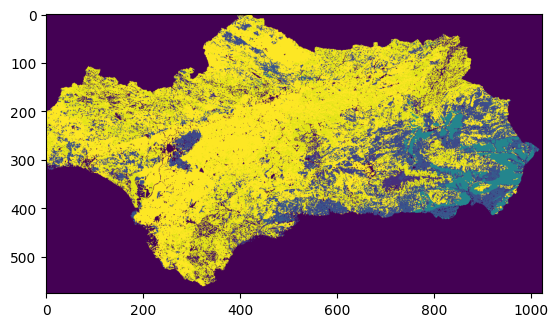

In [59]:
print(set(risks.flatten()))#get set of unique values
plt.imshow(risks)
plt.show()

(100, 200)

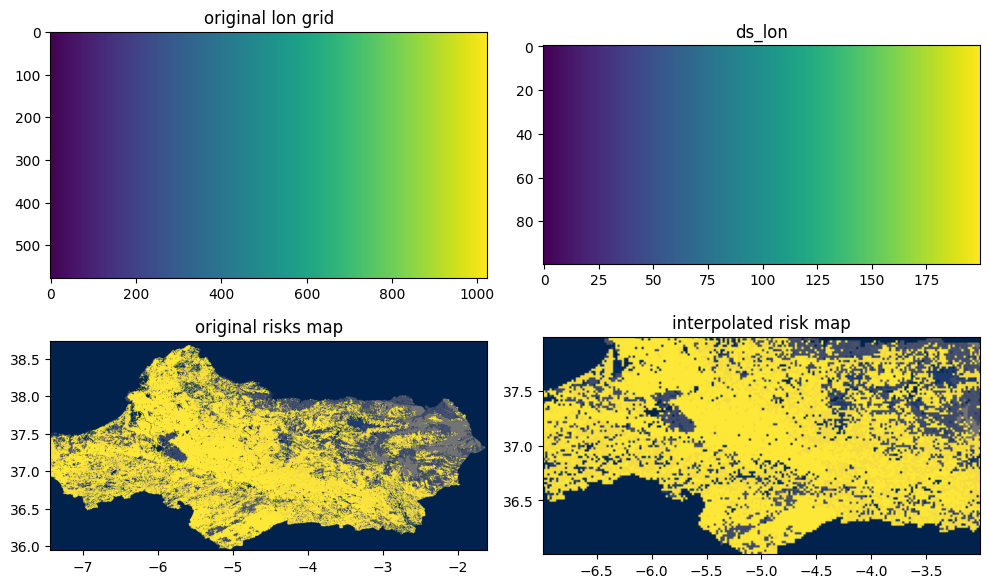

In [60]:
#### extract on area of interest, then reshape with the same size/resolution as other datasets
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting


ny,nx=risks.shape

# Create 1D arrays for latitudes and longitudes for risk image
lons = np.linspace(bbox[0], bbox[2], nx)
lats = np.linspace(bbox[1], bbox[3], ny)

# Use np.meshgrid to create 2D arrays (matrices) of the coordinates
lon_grid, lat_grid = np.meshgrid(lons, lats)


# Perform interpolation
interpolator = RegularGridInterpolator((lats, lons), risks,
                                       bounds_error=False,fill_value=np.nan,
                                       method='nearest') # linear create artefacts (4,7,8,...) value that should not exist

ds_lon,ds_lat,=np.meshgrid(DEM_ds['lon'],DEM_ds['lat'])

im_interp=interpolator((ds_lat,ds_lon))
#print(np.nanmax(im_interp))


#### see results
#plt.imshow(im_interp)
fig,ax=plt.subplots(2,2,figsize=(10,6))
ax[0,0].imshow(lon_grid)
ax[0,1].imshow(ds_lon)
ax[1,0].imshow(risks, extent=[bbox[0], bbox[2], bbox[1], bbox[3]],
               origin='lower', cmap='cividis')
ax[1,1].imshow(im_interp, extent=[DEM_ds['lon'].min(), DEM_ds['lon'].max(), DEM_ds['lat'].min(), DEM_ds['lat'].max()],
               origin='lower', cmap='cividis')

ax[0,0].set_title('original lon grid')
ax[0,1].set_title('ds_lon')
ax[1,0].set_title('original risks map')
ax[1,1].set_title('interpolated risk map')

plt.tight_layout()
fig.show()

im_interp.shape

In [61]:
im_interp[50:60,50:60]

array([[ 0., 22., 21., 21., 21.,  5., 22., 22.,  6., 22.],
       [ 1.,  5., 21., 21.,  5., 21., 21., 21.,  6., 21.],
       [21.,  5., 22., 22., 22.,  5., 22.,  6.,  6.,  6.],
       [22., 21., 22., 21., 22.,  5., 22., 22.,  0., 22.],
       [22., 22., 22., 22., 22., 22., 22., 22., 22., 22.],
       [22., 22., 22., 22., 22., 22., 22., 22., 22., 22.],
       [22., 22., 22., 22., 22., 22.,  0., 22., 22.,  5.],
       [22., 22., 22., 22., 22., 22.,  5., 22.,  5.,  5.],
       [22., 22.,  0.,  0., 22., 22., 22.,  5.,  5.,  5.],
       [22., 22., 22., 22., 22.,  0., 22., 22.,  5.,  5.]])

In [62]:
import xarray as xr
#check  legend in the .odt at
#https://portalrediam.cica.es/descargas/index.php/s/mxHMWXyHfrCxyNK?dir=/06_RIESGOS_NATURALES_TECNOLOG/01_RIESGOS_NATURALES/04_DESERTIFICACION/00_DESERTIFICACION/Desert_1956_2100/Documentos

Risklegend = {
    0: 'No evaluacion',
    1: 'No desertification, no proces',
    21:'No desertification, with high risk',
    22:'No desertification, with strong risk',
    3: 'Desertificable area, with high risk',
    5: 'Desertificable area, with strong risk',
    6: 'Desertificable area, with active processes',
    9: 'Desertificable area, with very active processes',
    10:'Heritated desert',
}



### need for integer value
risks_interp=np.array( np.round(im_interp,0)) #,dtype=int) #adding dtype give wrong min value!
print(risks_interp.min(),risks_interp.max())
print(risks_interp.shape)
print('unique values before interp', np.unique(risks))
print('unique values after interp' , np.unique(risks_interp))


## interpolation create some wrong values!
#check how much this happen
artefacts=set(np.unique(risks_interp))-set(np.unique(risks))
for art in artefacts:
  count=np.count_nonzero(risks_interp==art)
  print(f'artefact {art} exist {count} times')


###just for quick visualization
print('example subset')
risks_interp[50:60,50:60]



#create dataset
Risk_ds=xr.Dataset(
    data_vars=dict(
        risk= (['lat', 'lon'], risks_interp),
    ),
    coords=dict(lon=DEM_ds['lon'], # Use the 1D 'lon' coordinate from DEM_ds
                lat=DEM_ds['lat']  # Use the 1D 'lat' coordinate from DEM_ds
                ),
)







0.0 22.0
(100, 200)
unique values before interp [ 0.  1.  3.  5.  6.  9. 10. 21. 22.]
unique values after interp [ 0.  1.  3.  5.  6.  9. 10. 21. 22.]
example subset


In [63]:
Risk_ds


<xarray.Dataset> Size: 162kB
Dimensions:  (lat: 100, lon: 200)
Coordinates:
  * lat      (lat) float64 800B 36.01 36.03 36.05 36.07 ... 37.95 37.97 37.99
  * lon      (lon) float64 2kB -6.99 -6.97 -6.95 -6.93 ... -3.05 -3.03 -3.01
Data variables:
    risk     (lat, lon) float64 160kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [64]:
##################ML classificiation
import xarray as xr

# remove SATVI because it show nothing, I don't know why
if 'SATVI' in Features:
    Features.remove('SATVI')


####### take some as known value for ml
#step 1: create a unified dataset! that is no time coord

def clean_ds_for_merge(ds):
    #note: #ds.drop_dims remove all variable...??? why
    # If 'time' is a dimension, squeeze it,
    if 'time' in ds.dims:
        ds = ds.squeeze('time')
    # # If 'time' is a coordinate
    if 'time' in ds.coords:
         ds = ds.drop_vars('time')

    return ds


# Combine all datasets into a single unified dataset
combined_ds = xr.merge([
    clean_ds_for_merge(LULC_ds),
    clean_ds_for_merge(DEMSlope_ds),
    clean_ds_for_merge(DEM_ds),
    clean_ds_for_merge(Weather_ds),
    clean_ds_for_merge(Landsat_ds[Features]),
#    clean_ds_for_merge(Sentinel_ds[Features]),
    clean_ds_for_merge(Risk_ds),
    #Sentinel_ds
])

combined_ds
#combined_ds.rename_vars({'Map':'LULC'},inplace=True)

<xarray.Dataset> Size: 2MB
Dimensions:                                        (lon: 200, lat: 100)
Coordinates:
  * lon                                            (lon) float64 2kB -6.99 .....
  * lat                                            (lat) float64 800B 36.01 ....
Data variables: (12/18)
    Map                                            (lon, lat) float32 80kB ...
    slope                                          (lon, lat) float32 80kB ...
    elevation                                      (lon, lat) float32 80kB ...
    temperature_2m                                 (lon, lat) float32 80kB ...
    total_precipitation_sum                        (lon, lat) float32 80kB ...
    evaporation_from_vegetation_transpiration_sum  (lon, lat) float32 80kB ...
    ...                                             ...
    BSI                                            (lon, lat) float32 80kB ...
    EVI                                            (lon, lat) float32 80kB ...
    LAI                                            (lon, lat) float32 80kB ...
    GNDVI                                          (lon, lat) float32 80kB ...
    CVI                                            (lon, lat) float32 80kB ...
    risk                                           (lat, lon) float64 160kB 0...
Attributes:
    crs:      EPSG:4326

In [65]:
############## CLEANING DATASET FOR ML

#target is desert risk # remove all data where this target is not known
DS=combined_ds.where(combined_ds.risk!=0)

# I dont think wind is important
DS=DS.drop_vars(['u_component_of_wind_10m','v_component_of_wind_10m'])



In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert combined_ds to a pandas DataFrame for easier ML processing
# First, stack the lat and lon dimensions to create a single 'sample' dimension
df = DS.stack(samples=['lat', 'lon']).to_dataframe()

# Drop any row with a nan
df_cleaned = df.dropna(axis=0)

# # Separate features (X) and target (y)
X = df_cleaned.drop('risk', axis=1)
y = df_cleaned['risk']

#because y classes is highly unbalanced, I simplify some classes to have less cases
y[y==22]=2 # no current desertificicaion but risk exist
y[y==23]=2 # no current desertificicaion but risk exist
y[y==5]=3 # merge 'Áreas potencialmente desertificables' together
y[y==9]=6 # merge area with active processes and area with very active processes


print(f'target/classes repartition {y.value_counts()}')



# Ensure target variable is integer type if it represents discrete classes
y = y.astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")




#### normalize?


# Initialize and train the Random Forest Classifier
# Using a small number of estimators for faster execution, adjust as needed.
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print(f"\nRandom Forest Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)


target/classes repartition risk
2.0     5822
21.0    3393
3.0     2127
6.0      510
1.0      274
10.0      87
Name: count, dtype: int64
Training set size: 8549 samples
Test set size: 3664 samples

Random Forest Classifier Accuracy: 0.5783

Classification Report:
              precision    recall  f1-score   support

           1       0.36      0.10      0.15        82
           2       0.64      0.81      0.71      1747
           3       0.48      0.36      0.41       638
           6       0.50      0.22      0.30       153
          10       0.48      0.46      0.47        26
          21       0.49      0.42      0.45      1018

    accuracy                           0.58      3664
   macro avg       0.49      0.39      0.42      3664
weighted avg       0.56      0.58      0.56      3664



In [67]:


##-> see later, the classification used is not good for ML as multiple classes target have the same meaning (e.g. 7 and 8) but are rare
## either upsample rare classes or down sample the too frequent one (21,22,22) which are 'No desertification'
#

In [68]:
stop

NameError: name 'stop' is not defined

In [ ]:
################################################################################################
################################################################################################
#################################### TIME SERIE ################################################



#I need long time here but a 'small' area because dat quantity is restricted
feature='NDVI' # index to analyze or a spectral band

poi = ee.Geometry.Point(lon,lat).buffer(1000) #point of interest with 10000m buffer circle area

date_i='2020-01-01'
date_f='2022-01-01' # I need one year at least to be able to do harmonic decomposition ('seasonal')
dates=(date_i,date_f)




#### adding some definition :
######################## Area averaging/median, std##################################

def poi_mean(img):
    '''
    Compute spatial average on a point of interest (small area) for all bands
    '''
    mean = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('mean',mean)
#
def poi_median(img):
    '''
    Compute spatial median on a point of interest (small area) for all bands
    '''
    median = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('median',median)


def poi_std(img):
    '''
    Compute spatial standard deviation on a point of interest (small area) for all bands
    '''
    mean = img.reduceRegion(reducer=ee.Reducer.stdDev(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('std',std)



######################## To dataframe##################################

def ImageColl_toDataFrame(ImageCollection,poi,method):
    '''
    Extract data for all bands and stack them into a dataframe
    '''
    if method=='mean':
        ImageColl_=ImageCollection.map(poi_mean)
    elif method=='std':
        ImageColl_=ImageCollection.map(poi_std)
    elif method=='median':
        ImageColl_=ImageCollection.map(poi_median)
    #
    reduced=ImageColl_.reduceColumns(ee.Reducer.toList(2), ['date',method]).values().get(0)
    data_sat=reduced.getInfo()
    #
    Df=dataSat_toDataFrame(data_sat)
    return Df


def dataSat_toDataFrame(data_sat):
    '''
    A code used in ImageColl_toDataFrame to transform satellite extracted data into a dataframe
    '''
    Q=pd.DataFrame()
    for i in range(len(data_sat)):
        time=data_sat[i][0]
        data=data_sat[i][1]
        testedkey=list(data.keys())[1]#could be other than 1, I just need a value to test
        if data[testedkey] is not None:
            q=pd.DataFrame.from_dict(data,orient='index').T
            q['time']=time
            Q=pd.concat([Q,q])
    #
    Q.index=Q.pop('time')
    return Q



#######end of definitions







Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)

BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)
Sentinel=Sentinel.map(compute_ndwi)
Sentinel=Sentinel.map(compute_bsi)
Sentinel=Sentinel.map(compute_satvi)

BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)
Landsat=Landsat.map(compute_ndwi)
Landsat=Landsat.map(compute_bsi)
Landsat=Landsat.map(compute_satvi)




#redo but on years and on point of interest, not whole large area

print('collecting mean values at given point')

method='median'
#Era5_df=ImageColl_toDataFrame(Era5,poi,method)
Land_df=ImageColl_toDataFrame(Landsat,poi,method)
Sent_df=ImageColl_toDataFrame(Sentinel,poi,method)

# convert time to timestamp
Land_df.index=pd.to_datetime(Land_df.index,utc=True)
Sent_df.index=pd.to_datetime(Sent_df.index,utc=True)


#remove date with no data
Land_df=Land_df.dropna(subset=feature)
Sent_df=Sent_df.dropna(subset=feature)

###landsat cycle is 16 days, sentinel is about 10 days,
# put them on the same time reference
Land_df=Land_df.resample('16D',axis=0).mean()
Sent_df=Sent_df.resample('16D',axis=0).mean()

#timeserie
timeformat='%Y-%m-%d'
timelabel=[x.strftime(timeformat) for x in Land_df.index]


n=4
fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_df.index,Land_df[feature],'r',label='Landsat8')
ax.plot(Sent_df.index,Sent_df[feature],'k',label='Sentinel2')
ax.set_xlabel('time')
ax.set_xticks(Land_df.index[::n], labels=timelabel[::n])
ax.tick_params(axis='x', labelrotation=45)
ax.set_title( feature )
fig.show()




In [ ]:
Land_df.index[:5]

In [ ]:

####rolling mean of x step? and/or exponential moving average?

#rolling mean
window = 4  # x step moving average
win_typ='hann'#'hanning' #default is boxcar
Land_rma = Land_df.rolling(window=window,win_type=win_typ,center=True,min_periods=1).mean()
Sent_rma = Sent_df.rolling(window=window,win_type=win_typ,center=True,min_periods=1).mean()

#exponential moving average
Land_ema = Land_df.ewm(halflife=window/2, adjust=False,ignore_na=True).mean()
Sent_ema = Sent_df.ewm(halflife=window/2, adjust=False,ignore_na=True).mean()

fig,ax=plt.subplots(2,figsize=(8,4),sharex=True,sharey=True)
ax[0].plot(Land_df.index,Land_df[feature],'r',label='direct obs')
ax[0].plot(Land_rma.index,Land_rma[feature],'g',label=' moving average')
ax[0].plot(Land_ema.index,Land_ema[feature],'b',label='exponential moving average')
ax[0].set_title('Landsat')
ax[0].legend()

ax[1].plot(Sent_df.index,Sent_df[feature],'r')
ax[1].plot(Sent_rma.index,Sent_rma[feature],'g')
ax[1].plot(Sent_ema.index,Sent_ema[feature],'b')
ax[1].set_title('Sentinel')

fig.show()



In [ ]:


### time serie decomposition!
#see https://www.geeksforgeeks.org/python/time-series-decomposition-techniques/
# and https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html

#resample on 15d and interpolate
#rolling mean induce nana.... cant be interpolated
Sent_df_smooth=Sent_ema.resample('16d').mean().interpolate(method='spline',order=1)
Land_df_smooth=Land_ema.resample('16d').mean().interpolate(method='spline',order=1)

#seasonal decompose does NOT handle missing value ... but sentinel as some gaps
#interpolation required before!
Sent_decomp = seasonal_decompose(Sent_df_smooth[feature], model='additive')#,period=365//16)
Land_decomp = seasonal_decompose(Land_df_smooth[feature], model='additive')


fig,ax=plt.subplots(4,1,figsize=(8,16),sharex=True)
ax[0].plot(Land_decomp.observed,'b',label='Landsat')
ax[0].plot(Sent_decomp.observed,'k',label='Sentinel')
ax[0].set_ylabel('observed signal - smoothed/ resampled')
ax[0].legend()
ax[0].set_title('Time serie for '+ feature +' at ('+ '{:0.2f}'.format(lat) +'N,'+ '{:0.2f}'.format(lon) +'E)')
#ax[0].tick_params(labelbottom=True)

ax[1].plot(Land_decomp.seasonal,'b')
ax[1].plot(Sent_decomp.seasonal,'k')
ax[1].set_ylabel('seasonal component ')

ax[2].plot(Land_decomp.trend,'b',label='Landsat')
ax[2].plot(Sent_decomp.trend,'k',label='Sentinel')
ax[2].set_ylabel('trend component')
ax[2].legend()

ax[3].plot(Land_decomp.resid,'b')
ax[3].plot(Sent_decomp.resid,'k')
ax[3].set_ylabel('residual ')

fig.show()



In [ ]:

############################################## PREDICTION
#by using ARIMA algorithm
# ARIMA= Autoregressive Integrated Moving Average
#https://medium.com/@hazallgultekin/time-series-analysis-and-forecasting-with-arima-8be02ba2665a
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.tsa.arima.model import ARIMA

#ordre=(p,q,d) The parameters of the ARIMA model are defined as follows:
#    p: The lag order, representing the number of lag observations incorporated in the model.
#    d: Degree of differencing, denoting the number of times raw observations undergo differencing.
#    q: Order of moving average, indicating the size of the moving average window.
ordre=(4, 1, 2)

#define optimal order p,d,q ???

nstep=round(Sent_df_smooth.shape[0]/4)

model = ARIMA(Land_df_smooth[feature], order=ordre)
model_fit = model.fit()
# Forecast next n time step, here a timestep=15days
Land_forecast = model_fit.forecast(steps=nstep)

model = ARIMA(Sent_df_smooth[feature], order=ordre)
model_fit = model.fit()
# Forecast next n time step, here a timestep=15days
Sent_forecast = model_fit.forecast(steps=nstep)

####

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_df_smooth.index,Land_df_smooth[feature],'b')
ax.plot(Sent_df_smooth.index,Sent_df_smooth[feature],'k')
ax.plot(Land_forecast.index,Land_forecast,'b',linestyle='dashed')
ax.plot(Sent_forecast.index,Sent_forecast,'k',linestyle='dashed')

fig.show()
